# MaxEnt Classification

### A. Concepts (ME as Generalized Logistic Regression)

** a. Classify By Probability **

* **Probability of a Classifying as $c$**: 
    * $p(c|x) = \frac{p(c,x)}{p(x)} = \frac{p(x|c)p(c)}{\sum_cp(x|c)p(c)} = \frac{exp\left(\sum_{i=0}^Nw_{ci}f_i\right)}{\sum_{c'\in C}exp\left(\sum_{i=0}^Nw_{c'i}f_i\right)} = \frac{exp\left(\sum_{i=0}^Nw_{ci}f_i(c,x)\right)}{\sum_{c'\in C}exp\left(\sum_{i=0}^Nw_{c'i}f_i(c',x)\right)}$
    * $f(c/c',x)$ is an indicator function indicating the presence/absence of a feature, which is binary-valued $\{0,1\}$. 


* **Best Class $\hat{c}$**: 
    * $\hat{c} = argmax_{c\in C}p(c|x)$.


* **Best Weights $\hat{w}$**:
    * $\hat{w} = argmax_w\sum_ilogp(y^{(i)}|x^{(i)})$, where $(x^{(i)}, y^{(i)})$ are training pairs.


* **NB**: 
    * For an excellent explanation for the use of exponential, cf. J&M ch6.6:26-8.
    * cf. J&M ch6.7:30-1, the original derivation in eq.6.79 is notationally incorrect, specifically $\sum_Cp(c|x)$ is equal to 1, instead of $\sum_{c'\in C}exp\left(\sum_{i=0}^Nw_{c'i}f_i\right)$.
    * Caveat: in practice, in sequence classification, MaxEnt classification described here is used as a part of a larger classifier, because our goal is to find the *best sequence of classification*, not *single-best classification for each unit in a sequence*.

** b. Finding Best Weights**

* **Maximizing Loglikelihood (i.e. MLE)**: (notation: $C$ for 'all classes' $D$ for all corresponding data)

    * $logp(C|D,w) = \sum_{(c,d)\in(C,D)}logexp\sum_iw_if_i(c,d) - \sum_{(c,d)\in(C,D)}log\sum_{c'}exp\sum_iw_if_i(c',d)$, the optimization goal is to find $w$ that maximizes $logp(C|D,w)$.
    
    * $\frac{\partial logp(C|D,w)}{\partial w_i} = \sum_{(c,d)\in(C,D)}f_i(c,d) - \sum_{(c,d)\in(C,D)}\sum_{c'}p(c'|d,w)f_i(c',d)$ (i.e. empirical - predicted. cf. Stanford MaxEnt Tutorial (SMT hereafter):24-7, http://people.eecs.berkeley.edu/~klein/papers/maxent-tutorial-slides.pdf)


* **Maximizing Posterior Probability (i.e. MAP)**:

    * We have some prior distribution of the weights: $p(w)$, and the likelihood of a class assignments $C$ given the data and weights is $p(C|D,w)$. Then, the posterior probability of the classification will be $p(w)\cdot p(C|D,w) = p(C,w|D)$. The optimization goal now is then finding the $w$ that maximizes the log-probability $logp(C,w|D)$, where $logp(C,w|D) = log(w) + logp(C|D,w)$.
    
    * $\frac{\partial logp(C,w|D)}{\partial w_i} = \sum_{(c,d)\in(C,D)}f_i(c,d) - \sum_{(c,d)\in(C,D)}\sum_{c'}p(c'|d,w)f_i(c',d) - \frac{(w_i - \mu_i)}{\sigma^2}$, assuming the prior $p(w)$ is *Gaussian*, i.e. $p(w) = \frac{1}{\sigma\sqrt{2\pi}}exp\left(-\frac{(w_i-\mu_i)^2}{2\sigma^2}\right)$, where $2\sigma^2 = 1$ works well empirically (cf. SMT:55).

### B. Basic Optimization (Logistic Regression)

In [6]:
import os
os.chdir('/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/NLP/DATA/')

In [76]:
import pandas as pd
import numpy as np
from __future__ import division
import scipy.optimize as sco

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

** a. Step-By-Step Demo **

In [10]:
data = pd.read_csv('carmpg.txt', sep='\s+', 
                  names=['mpg','cylinders','displacement','horsepower',
                         'weight','acceleration','model_year','origin','car_name'])
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


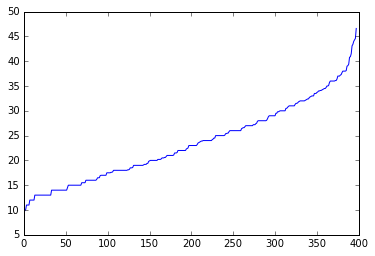

In [42]:
# TARGET
plt.plot(sorted(data['mpg']))

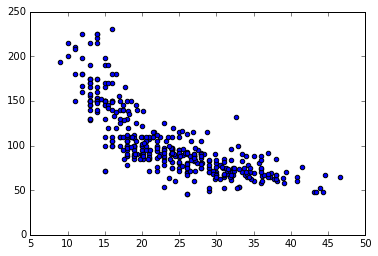

In [26]:
# 1 NEGATIVE PREDICTOR
plt.scatter(data['mpg'],data['horsepower'])

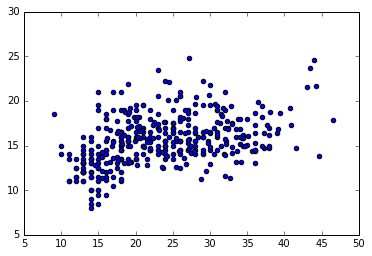

In [40]:
# 1 POSITIVE PREDICTOR
plt.scatter(data['mpg'],data['acceleration'])

In [21]:
mean = np.mean(data['mpg'])
data['high_mpg'] = map(lambda x:1 if x>mean else 0, data['mpg'])

In [22]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,high_mpg
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino,0


In [47]:
data[['horsepower','acceleration']].head()

,horsepower,acceleration
0,130.0,12.0
1,165.0,11.5
2,150.0,11.0
3,150.0,12.0
4,140.0,10.5


In [123]:
def normalize(x):
    return ((x - np.mean(x)) / np.std(x))[:,np.newaxis]

In [124]:
X, Y = np.hstack((np.ones((len(data),1)),
                  normalize(np.array(data['horsepower'])),
                  normalize(np.array(data['acceleration'])))), \
       np.array(data['high_mpg'])

In [172]:
W = np.random.random(3) # bias, W_1 for X_1 horsepower, W_2 for X_2 acceleration.

In [127]:
def fx(W_i,X_i):
    return 1 / (1 + np.exp(-np.dot(W_i,X_i)))
def log(Z): # Z = dot(W,X)
    return np.nan_to_num(np.log(Z))

In [173]:
def cost(W,X,Y):
    return sum(- Y_i*log(fx(W,X_i)) - (1-Y_i)*log(1-fx(W,X_i))
               for X_i,Y_i in zip(X,Y))

In [175]:
cost(W,X,Y)

465.1083806224982

In [177]:
W

array([ 0.9127471 ,  0.8829892 ,  0.00966863])

In [176]:
X

array([[ 1.        ,  0.67602454, -1.29549834],
       [ 1.        ,  1.58967758, -1.47703779],
       [ 1.        ,  1.19811199, -1.65857724],
       ..., 
       [ 1.        , -0.52477659, -1.4407299 ],
       [ 1.        , -0.65529846,  1.10082237],
       [ 1.        , -0.57698534,  1.39128549]])

In [184]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1,

In [185]:
print W.shape, X.shape, Y.shape

(3,) (398, 3) (398,)


In [181]:
%%time
optimizer = sco.minimize(cost, x0=W, args=(X,Y), method='BFGS', options={'gtol':1e-3,'disp':True})
    # sco.show_options()

Optimization terminated successfully.
         Current function value: 128.916750
         Iterations: 11
         Function evaluations: 220
         Gradient evaluations: 43
CPU times: user 4.16 s, sys: 14.9 ms, total: 4.17 s
Wall time: 4.17 s


In [182]:
print optimizer # optimizer.w returns weights.

      fun: 128.91675011369514
 hess_inv: array([[ 0.06058744,  0.08671553,  0.00419772],
       [ 0.08671553,  0.29774318,  0.07414673],
       [ 0.00419772,  0.07414673,  0.05888036]])
      jac: array([  5.16891479e-04,  -4.95910645e-05,  -2.47955322e-04])
  message: 'Optimization terminated successfully.'
     nfev: 220
      nit: 11
     njev: 43
   status: 0
  success: True
        x: array([-1.13055845, -4.9644916 , -1.17704356])
